# Self-Organized Criticality

Port of [Think Complexity chapter 8](http://greenteapress.com/complexity2/html/index.html) by Allen Downey.

In [67]:
using Pkg
pkg"add StatsPlots.jl"

using Luxor
using Plots
using StatsPlots

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1242


## Critical Systems

Many critical systems demonstrate common behaviors:

- Fractal geometry: For example, freezing water tends to form fractal patterns, including snowflakes and other crystal structures. Fractals are characterized by self-similarity; that is, parts of the pattern are similar to scaled copies of the whole.

- Heavy-tailed distributions of some physical quantities: For example, in freezing water the distribution of crystal sizes is characterized by a power law.

- Variations in time that exhibit pink noise: Complex signals can be decomposed into their frequency components. In pink noise, low-frequency components have more power than high-frequency components. Specifically, the power at frequency f is proportional to 1/f.

Critical systems are usually unstable. For example, to keep water in a partially frozen state requires active control of the temperature. If the system is near the critical temperature, a small deviation tends to move the system into one phase or the other.

## Sand Piles

The sand pile model was proposed by Bak, Tang and Wiesenfeld in 1987. It is not meant to be a realistic model of a sand pile, but rather an abstraction that models physical systems with a large number of elements that interact with their neighbors.

The sand pile model is a 2-D cellular automaton where the state of each cell represents the slope of a part of a sand pile. During each time step, each cell is checked to see whether it exceeds a critical value, `K`, which is usually 3. If so, it “topples” and transfers sand to four neighboring cells; that is, the slope of the cell is decreased by 4, and each of the neighbors is increased by 1. At the perimeter of the grid, all cells are kept at slope 0, so the excess spills over the edge.

Bak, Tang and Wiesenfeld initialize all cells at a level greater than `K` and run the model until it stabilizes. Then they observe the effect of small perturbations: they choose a cell at random, increment its value by 1, and run the model again until it stabilizes.

For each perturbation, they measure `T`, the number of time steps the pile takes to stabilize, and `S`, the total number of cells that topple.

Most of the time, dropping a single grain causes no cells to topple, so `T=1` and `S=0`. But occasionally a single grain can cause an avalanche that affects a substantial fraction of the grid. The distributions of `T` and `S` turn out to be heavy-tailed, which supports the claim that the system is in a critical state.

They conclude that the sand pile model exhibits “self-organized criticality”, which means that it evolves toward a critical state without the need for external control or what they call “fine tuning” of any parameters. And the model stays in a critical state as more grains are added.

In the next few sections I replicate their experiments and interpret the results.

## Implementation

In [7]:
function applytoppling(array::Array{Int64, 2}, K::Int64=3)
    out = copy(array)
    (ydim, xdim) = size(array)
    numtoppled = 0
    for y in 2:ydim-1
        for x in 2:xdim-1
            if array[y,x] > K
                numtoppled += 1
                out[y-1:y+1,x-1:x+1] += [0 1 0;1 -4 1;0 1 0]
            end
        end
    end
    out[1,:] .= 0
    out[end, :] .= 0
    out[:, 1] .= 0
    out[:, end] .= 0
    out, numtoppled
end

applytoppling (generic function with 2 methods)

In [21]:
pile = [0 0 0 0 0 0 0;
        0 0 0 0 0 0 0;
        0 0 4 0 4 0 0;
        0 0 0 0 0 0 0;
        0 0 0 0 0 0 0;]
pile, num = applytoppling(pile)
pile

5×7 Array{Int64,2}:
 0  0  0  0  0  0  0
 0  0  1  0  1  0  0
 0  1  0  2  0  1  0
 0  0  1  0  1  0  0
 0  0  0  0  0  0  0

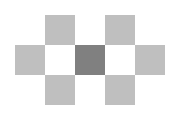

In [26]:
function visualizepile(array::Array{Int64, 2}, dim, scale)
    (ydim, xdim) = size(array)
    width = dim * (xdim - 1)
    height = dim * (ydim - 1)
    Drawing(width, height, "out.svg")
    for (j, y) in enumerate(2:ydim-1)
        for (i, x) in enumerate(2:xdim-1)
            sethue(setgrey(1-array[y,x]/scale))
            box(i*dim, j*dim, dim, dim, :fill)
        end
     end
     finish()
     preview()
end
visualizepile(pile, 30, 4)

In [18]:
function steptoppling(array::Array{Int64, 2}, K::Int64=3)
    total = 0
    i = 0
    while true
        array, numtoppled = applytoppling(array, K)
        total += numtoppled
        i += 1
        if numtoppled == 0
            return array, i, total
        end
    end
end

steptoppling (generic function with 2 methods)

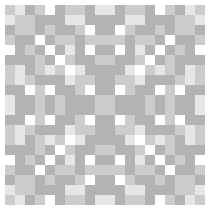

In [54]:
pile = zeros(Int64, 22, 22)
pile[2:end-1, 2:end-1] = 10 * ones(Int64, 20, 20)
pile, steps, total = steptoppling(pile)
visualizepile(pile, 10, 10)

With an initial level of 10, this sand pile takes 332 time steps to reach equilibrium, with a total of 53,336 topplings. The figure shows the configuration after this initial run. Notice that it has the repeating elements that are characteristic of fractals. We’ll come back to that soon.

In [38]:
function drop(array::Array{Int64, 2})
    (ydim, xdim) = size(array)
    y = rand(2:ydim-1)
    x = rand(2:xdim-1)
    array[y,x] += 1
    array
end

drop (generic function with 1 method)

In [43]:
function runtoppling(array::Array{Int64, 2}, iter=200)
    array, steps, total = steptoppling(array, 3)
    for _ in 1:iter
        array = drop(array)
        array, steps, total = steptoppling(array, 3)
    end
    array
end

runtoppling (generic function with 4 methods)

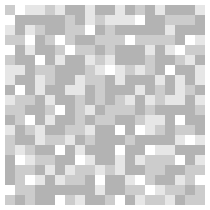

In [56]:
pile = zeros(Int64, 22, 22)
pile[2:end-1, 2:end-1] = 10 * ones(Int64, 20, 20)
pile, steps, total = steptoppling(pile)
for i in 1:200
    pile = drop(pile)
    pile, steps, total = steptoppling(pile)
    if mod(i, 10) == 0
        visualizepile(pile, 10, 10)
        sleep(1)
    end
end

The figure shows the configuration of the sand pile after dropping 200 grains onto random cells, each time running until the pile reaches equilibrium. The symmetry of the initial configuration has been broken; the configuration looks random.

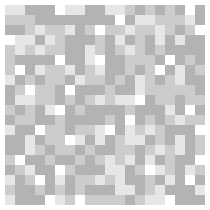

In [53]:
for i in 1:200
    pile = drop(pile)
    pile, steps, total = steptoppling(pile)
end
visualizepile(pile, 10, 10)

Finally the figure shows the configuration after 400 drops. It looks similar to the configuration after 200 drops. In fact, the pile is now in a steady state where its statistical properties don’t change over time. I’ll explain some of those statistical properties in the next section.

## Heavy-Tailed Distributions

If the sand pile model is in a critical state, we expect to find heavy-tailed distributions for quantities like the duration and size of avalanches. So let’s take a look.

I’ll make a larger sand pile, with n=50 and an initial level of 30, and run until equilibrium:

In [58]:
pile = zeros(Int64, 52, 52)
pile[2:end-1, 2:end-1] = 30 * ones(Int64, 50, 50)
pile, steps, total = steptoppling(pile)

([0 0 … 0 0; 0 2 … 2 0; … ; 0 2 … 2 0; 0 0 … 0 0], 5611, 6608352)

Next, I’ll run 100,000 random drops

In [79]:
durations = Int64[]
avalanches = Int64[]
for i in 1:100000
    pile = drop(pile)
    pile, steps, total = steptoppling(pile)
    push!(durations, steps)
    push!(avalanches, total)
end

A large majority of drops have duration 1 and no toppled cells; if we filter them out before plotting, we get a clearer view of the rest of the distribution.

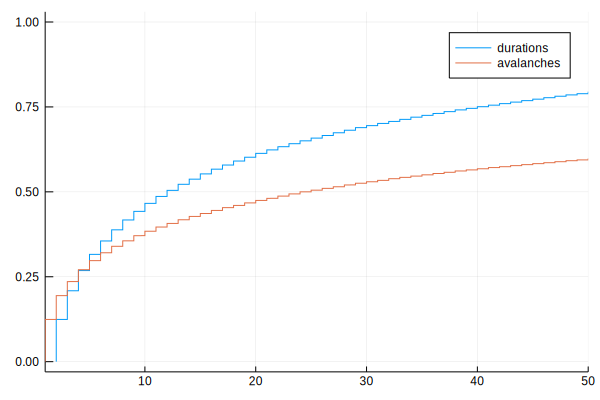

In [84]:
durations = filter(steps->steps>1, durations)
avalanches = filter(total->total>0, avalanches)
plot(sort(durations), 0:1/(length(durations)-1):1, label="durations", xlims = (2,50))
plot!(sort(avalanches), 0:1/(length(avalanches)-1):1, label="avalanches", xlims = (1,50))